In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Optuna for hyperparameter tuning
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

print(f"Libraries loaded successfully")

Libraries loaded successfully


In [2]:
# Load data
train_df = pd.read_csv('../data/training_data.csv')
test_df = pd.read_csv('../data/test_data.csv')

# Convert timestamp
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Training data: (208910, 21)
Test data: (52228, 20)


In [3]:
# Feature engineering function (from V1 working baseline)
def engineer_features(df, is_training=True):
    """
    Create advanced features for wind turbine power prediction.
    """
    df = df.copy()
    
    # ========== Temporal Features ==========
    df['hour'] = df['timestamp'].dt.hour
    df['month'] = df['timestamp'].dt.month
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['quarter'] = df['timestamp'].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # Cyclic encoding for time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    
    # ========== Wind Speed Features ==========
    df['wind_speed_squared'] = df['wind_speed_avg'] ** 2
    df['wind_speed_cubed'] = df['wind_speed_avg'] ** 3
    df['wind_speed_sqrt'] = np.sqrt(df['wind_speed_avg'])
    
    df['wind_speed_diff'] = np.abs(df['wind_speed1'] - df['wind_speed2'])
    df['wind_speed_ratio'] = df['wind_speed1'] / (df['wind_speed2'] + 0.001)
    df['wind_speed_max'] = df[['wind_speed1', 'wind_speed2']].max(axis=1)
    df['wind_speed_min'] = df[['wind_speed1', 'wind_speed2']].min(axis=1)
    
    # ========== Air Density Proxy ==========
    df['temp_kelvin'] = df['outdoor_temp'] + 273.15
    df['air_density_proxy'] = df['pressure'] / df['temp_kelvin']
    df['wind_power_theoretical'] = df['air_density_proxy'] * df['wind_speed_cubed']
    
    # ========== Direction Features ==========
    df['wind_nacelle_diff'] = np.abs(df['wind_angle'] - df['nacelle_angle'])
    df['wind_nacelle_diff'] = df['wind_nacelle_diff'].apply(lambda x: min(x, 360 - x) if x > 180 else x)
    df['wind_vane_diff'] = np.abs(df['wind_angle'] - df['vane_angle'])
    df['wind_vane_diff'] = df['wind_vane_diff'].apply(lambda x: min(x, 360 - x) if x > 180 else x)
    df['nacelle_alignment'] = np.cos(np.radians(df['wind_nacelle_diff']))
    
    # ========== Temperature Features ==========
    df['temp_diff'] = df['outdoor_temp'] - df['nacelle_temp']
    df['weather_outdoor_temp_diff'] = df['weather_temp'] - df['outdoor_temp']
    
    # ========== Rotor Features ==========
    df['rotor_angular_velocity_squared'] = df['rotor_angular_velocity'] ** 2
    
    # ========== Pitch Angle Features ==========
    df['is_shutdown'] = (df['pitch_angle'] > 40).astype(int)
    df['pitch_angle_squared'] = df['pitch_angle'] ** 2
    
    # ========== Weather Features ==========
    df['weather_wind_diff'] = np.abs(df['weather_wind_speed'] - df['wind_speed_avg'])
    df['has_rain'] = (df['rain_1h'] > 0).astype(int)
    df['has_snow'] = (df['snow_1h'] > 0).astype(int)
    
    # ========== Interaction Features ==========
    df['wind_temp_interaction'] = df['wind_speed_avg'] * df['outdoor_temp']
    df['wind_pressure_interaction'] = df['wind_speed_avg'] * df['pressure']
    df['wind_humidity_interaction'] = df['wind_speed_avg'] * df['humidity']
    df['rotor_wind_interaction'] = df['rotor_angular_velocity'] * df['wind_speed_avg']
    
    # ========== Rolling Features (only for training) ==========
    if is_training:
        window_sizes = [6, 12, 24]
        for window in window_sizes:
            df[f'wind_speed_rolling_mean_{window}'] = df['wind_speed_avg'].rolling(window=window, min_periods=1).mean()
            df[f'wind_speed_rolling_std_{window}'] = df['wind_speed_avg'].rolling(window=window, min_periods=1).std()
            df[f'power_rolling_mean_{window}'] = df['active_power'].rolling(window=window, min_periods=1).mean() if 'active_power' in df.columns else 0
    
    return df

print("Feature engineering function loaded")

Feature engineering function loaded


In [4]:
# Apply feature engineering
print("Engineering features...")
train_engineered = engineer_features(train_df, is_training=True)
test_engineered = engineer_features(test_df, is_training=False)

print(f"Engineered training features: {train_engineered.shape[1]}")
print(f"Engineered test features: {test_engineered.shape[1]}")

Engineering features...
Engineered training features: 67
Engineered test features: 57


In [5]:
# Prepare features
exclude_cols = ['timestamp', 'active_power']
train_features = [col for col in train_engineered.columns if col not in exclude_cols]
test_features = [col for col in test_engineered.columns if col != 'timestamp']
common_features = sorted(list(set(train_features) & set(test_features)))

X = train_engineered[common_features]
y = train_engineered['active_power']
X_test = test_engineered[common_features]

# Clean data
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X.median())

print(f"Features: {len(common_features)}")
print(f"Training samples: {len(X)}")
print(f"Test samples: {len(X_test)}")

Features: 56
Training samples: 208910
Test samples: 52228


In [6]:
# Split data (chronological)
split_idx = int(len(X) * 0.8)
X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {X_train_scaled.shape}")
print(f"Validation: {X_val_scaled.shape}")
print(f"Test: {X_test_scaled.shape}")

Training: (167128, 56)
Validation: (41782, 56)
Test: (52228, 56)


## 1. Hyperparameter Optimization with Optuna

This section implements Bayesian optimization using Optuna to fine-tune the hyperparameters of the XGBoost model. Optuna offers several advantages over traditional grid or random search methods:
- **Efficient Search**: Utilizes Bayesian optimization to explore the hyperparameter space more effectively.
- **Pruning**: Automatically terminates unpromising trials to save computational resources.
- **Flexibility**: Allows for complex objective functions and constraints.

In [7]:
# Define Optuna objective function
def objective(trial):
    """
    Objective function for Optuna to minimize (MAE)
    Conservative search space around V1 defaults
    """
    # Suggest hyperparameters (conservative ranges)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 80, 300),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.3),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2.0),
        'random_state': 42,
        'n_jobs': -1,
        'objective': 'reg:squarederror',
        'early_stopping_rounds': 20
    }
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    mae_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
        X_tr, X_vl = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_vl = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Train with early stopping
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_vl, y_vl)],
            verbose=False
        )
        
        # Predict and score
        pred = model.predict(X_vl)
        mae = mean_absolute_error(y_vl, pred)
        mae_scores.append(mae)
        
        # Report intermediate value for pruning
        trial.report(mae, fold)
        
        # Prune if not promising
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return np.mean(mae_scores)

print("Objective function defined")

Objective function defined


In [8]:
# Create Optuna study and optimize
print("Starting Optuna optimization...")

# Create study (minimize MAE)
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
)

# Optimize
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "="*60)
print("OPTIMIZATION COMPLETE")
print("="*60)
print(f"Best MAE: {study.best_value:.4f}")
print(f"\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-21 18:15:22,645] A new study created in memory with name: no-name-8f202591-8feb-4e63-948f-cfc76c9c6148


Starting Optuna optimization...


Best trial: 0. Best value: 10.9167:   2%|▏         | 1/50 [00:08<06:34,  8.06s/it]

[I 2025-11-21 18:15:30,705] Trial 0 finished with value: 10.916742254188165 and parameters: {'n_estimators': 160, 'max_depth': 9, 'learning_rate': 0.058750516552510644, 'subsample': 0.7120218647282072, 'colsample_bytree': 0.9619613696495866, 'min_child_weight': 1, 'gamma': 0.16631321661027107, 'reg_alpha': 0.1088792901914366, 'reg_lambda': 0.597805855975795}. Best is trial 0 with value: 10.916742254188165.


Best trial: 0. Best value: 10.9167:   4%|▍         | 2/50 [00:14<05:40,  7.09s/it]

[I 2025-11-21 18:15:37,117] Trial 1 finished with value: 11.013564514224129 and parameters: {'n_estimators': 115, 'max_depth': 10, 'learning_rate': 0.1497205649499614, 'subsample': 0.980753551462581, 'colsample_bytree': 0.9428021515171934, 'min_child_weight': 3, 'gamma': 0.0010725267898844758, 'reg_alpha': 0.41759893462805675, 'reg_lambda': 1.1933453945176264}. Best is trial 0 with value: 10.916742254188165.


Best trial: 2. Best value: 10.8915:   6%|▌         | 3/50 [00:16<03:43,  4.76s/it]

[I 2025-11-21 18:15:39,114] Trial 2 finished with value: 10.891462799583044 and parameters: {'n_estimators': 81, 'max_depth': 7, 'learning_rate': 0.08947198819721328, 'subsample': 0.7270566830313209, 'colsample_bytree': 0.9428209151570065, 'min_child_weight': 7, 'gamma': 0.05303805311489895, 'reg_alpha': 0.19238639503603028, 'reg_lambda': 1.9382505853919563}. Best is trial 2 with value: 10.891462799583044.


Best trial: 2. Best value: 10.8915:   8%|▊         | 4/50 [00:19<03:00,  3.92s/it]

[I 2025-11-21 18:15:41,732] Trial 3 finished with value: 10.971076698321903 and parameters: {'n_estimators': 263, 'max_depth': 7, 'learning_rate': 0.11809972085658885, 'subsample': 0.926036880158999, 'colsample_bytree': 0.7067879613910687, 'min_child_weight': 7, 'gamma': 0.10770986155140214, 'reg_alpha': 0.32163044399653845, 'reg_lambda': 1.9168748002293128}. Best is trial 2 with value: 10.891462799583044.


Best trial: 2. Best value: 10.8915:  10%|█         | 5/50 [00:21<02:26,  3.25s/it]

[I 2025-11-21 18:15:43,800] Trial 4 finished with value: 11.188003088546376 and parameters: {'n_estimators': 277, 'max_depth': 6, 'learning_rate': 0.10963961587298061, 'subsample': 0.958872029917172, 'colsample_bytree': 0.8831094795137967, 'min_child_weight': 6, 'gamma': 0.20868953680492933, 'reg_alpha': 0.17382311970444453, 'reg_lambda': 1.2563890632349533}. Best is trial 2 with value: 10.891462799583044.


Best trial: 5. Best value: 10.7475:  12%|█▏        | 6/50 [00:31<04:07,  5.62s/it]

[I 2025-11-21 18:15:54,028] Trial 5 finished with value: 10.747482311231343 and parameters: {'n_estimators': 276, 'max_depth': 10, 'learning_rate': 0.059247095322426245, 'subsample': 0.7027714551878399, 'colsample_bytree': 0.7593607437471638, 'min_child_weight': 4, 'gamma': 0.22608275614634044, 'reg_alpha': 0.07729997733779898, 'reg_lambda': 1.2466418507593047}. Best is trial 5 with value: 10.747482311231343.


Best trial: 5. Best value: 10.7475:  14%|█▍        | 7/50 [00:32<03:04,  4.29s/it]

[I 2025-11-21 18:15:55,568] Trial 6 finished with value: 11.581693521860842 and parameters: {'n_estimators': 117, 'max_depth': 5, 'learning_rate': 0.150227815612198, 'subsample': 0.8878000638410732, 'colsample_bytree': 0.7664280962202046, 'min_child_weight': 6, 'gamma': 0.10499337959743683, 'reg_alpha': 0.16503777499256228, 'reg_lambda': 1.166627130161379}. Best is trial 5 with value: 10.747482311231343.


Best trial: 5. Best value: 10.7475:  16%|█▌        | 8/50 [00:35<02:32,  3.62s/it]

[I 2025-11-21 18:15:57,760] Trial 7 finished with value: 11.245164868023735 and parameters: {'n_estimators': 185, 'max_depth': 7, 'learning_rate': 0.17524703330826172, 'subsample': 0.889138971788073, 'colsample_bytree': 0.9069308021575582, 'min_child_weight': 6, 'gamma': 0.12298270294584016, 'reg_alpha': 0.031780815905734006, 'reg_lambda': 1.152597508241953}. Best is trial 5 with value: 10.747482311231343.


Best trial: 5. Best value: 10.7475:  18%|█▊        | 9/50 [00:42<03:21,  4.90s/it]

[I 2025-11-21 18:16:05,483] Trial 8 finished with value: 11.030938843377713 and parameters: {'n_estimators': 269, 'max_depth': 9, 'learning_rate': 0.12177621936932818, 'subsample': 0.970153012680801, 'colsample_bytree': 0.8719536827713951, 'min_child_weight': 1, 'gamma': 0.09769527055898292, 'reg_alpha': 0.23822504024151164, 'reg_lambda': 0.9809222462003439}. Best is trial 5 with value: 10.747482311231343.


Best trial: 5. Best value: 10.7475:  20%|██        | 10/50 [00:45<02:50,  4.27s/it]

[I 2025-11-21 18:16:08,348] Trial 9 finished with value: 11.188220351861602 and parameters: {'n_estimators': 233, 'max_depth': 9, 'learning_rate': 0.25128081444269773, 'subsample': 0.9845808024015106, 'colsample_bytree': 0.84651418860098, 'min_child_weight': 3, 'gamma': 0.20106909789235725, 'reg_alpha': 0.2717757510606135, 'reg_lambda': 0.8427918947750201}. Best is trial 5 with value: 10.747482311231343.


Best trial: 10. Best value: 10.665:  22%|██▏       | 11/50 [00:55<03:54,  6.01s/it]

[I 2025-11-21 18:16:18,297] Trial 10 finished with value: 10.664980383379893 and parameters: {'n_estimators': 223, 'max_depth': 10, 'learning_rate': 0.05000709344880247, 'subsample': 0.7990811319149498, 'colsample_bytree': 0.7973487256979009, 'min_child_weight': 4, 'gamma': 0.2791770712173287, 'reg_alpha': 0.00025539889400810756, 'reg_lambda': 1.5050035287222268}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  24%|██▍       | 12/50 [01:04<04:19,  6.82s/it]

[I 2025-11-21 18:16:26,984] Trial 11 finished with value: 10.737592796003419 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.056259856428129675, 'subsample': 0.7944292042727991, 'colsample_bytree': 0.7833955153268659, 'min_child_weight': 4, 'gamma': 0.29540545977313376, 'reg_alpha': 0.0038336485768533297, 'reg_lambda': 1.5506963006868848}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  26%|██▌       | 13/50 [01:06<03:18,  5.38s/it]

[I 2025-11-21 18:16:29,030] Trial 12 finished with value: 11.997460281677908 and parameters: {'n_estimators': 221, 'max_depth': 4, 'learning_rate': 0.05237763104827681, 'subsample': 0.788877154633204, 'colsample_bytree': 0.8118638995038346, 'min_child_weight': 4, 'gamma': 0.2999943297414406, 'reg_alpha': 0.017839762902122514, 'reg_lambda': 1.5639857789251683}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  28%|██▊       | 14/50 [01:14<03:46,  6.28s/it]

[I 2025-11-21 18:16:37,405] Trial 13 finished with value: 10.75076198704206 and parameters: {'n_estimators': 211, 'max_depth': 10, 'learning_rate': 0.079110706356075, 'subsample': 0.7972818305723518, 'colsample_bytree': 0.8047318120619884, 'min_child_weight': 3, 'gamma': 0.2981799752194685, 'reg_alpha': 0.014584332262624143, 'reg_lambda': 1.6373591524223867}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  30%|███       | 15/50 [01:18<03:08,  5.39s/it]

[I 2025-11-21 18:16:40,731] Trial 14 finished with value: 10.92149394443274 and parameters: {'n_estimators': 168, 'max_depth': 8, 'learning_rate': 0.07489867640319957, 'subsample': 0.7849111228184937, 'colsample_bytree': 0.7107132098474804, 'min_child_weight': 5, 'gamma': 0.2619585059055667, 'reg_alpha': 0.493226213311269, 'reg_lambda': 1.5281046233864417}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  32%|███▏      | 16/50 [01:22<02:52,  5.08s/it]

[I 2025-11-21 18:16:45,099] Trial 15 finished with value: 10.730750237324202 and parameters: {'n_estimators': 241, 'max_depth': 8, 'learning_rate': 0.06661761080158472, 'subsample': 0.8306221889947939, 'colsample_bytree': 0.7722033140339915, 'min_child_weight': 2, 'gamma': 0.2551967897556824, 'reg_alpha': 0.11972208919071278, 'reg_lambda': 1.4397340671794145}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  34%|███▍      | 17/50 [01:26<02:33,  4.64s/it]

[I 2025-11-21 18:16:48,701] Trial 16 finished with value: 10.752769513986536 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.07351349668468925, 'subsample': 0.8436907087829343, 'colsample_bytree': 0.7468560757897974, 'min_child_weight': 2, 'gamma': 0.25484053792188605, 'reg_alpha': 0.12645975945001503, 'reg_lambda': 1.7360152965126152}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  36%|███▌      | 18/50 [01:31<02:34,  4.84s/it]

[I 2025-11-21 18:16:54,011] Trial 17 finished with value: 10.784026168891982 and parameters: {'n_estimators': 241, 'max_depth': 8, 'learning_rate': 0.05011939301724148, 'subsample': 0.8335274351296269, 'colsample_bytree': 0.8409320317942943, 'min_child_weight': 2, 'gamma': 0.24926152617599281, 'reg_alpha': 0.07147827347049346, 'reg_lambda': 1.481154039876529}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  38%|███▊      | 19/50 [01:33<02:04,  4.01s/it]

[I 2025-11-21 18:16:56,097] Trial 18 finished with value: 11.098389809021151 and parameters: {'n_estimators': 198, 'max_depth': 6, 'learning_rate': 0.09447108829001681, 'subsample': 0.7483140487156841, 'colsample_bytree': 0.8079333017447453, 'min_child_weight': 2, 'gamma': 0.19436017587577056, 'reg_alpha': 0.07908201269051933, 'reg_lambda': 1.3999865863146732}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  40%|████      | 20/50 [01:39<02:20,  4.67s/it]

[I 2025-11-21 18:17:02,305] Trial 19 finished with value: 10.855285576613893 and parameters: {'n_estimators': 248, 'max_depth': 9, 'learning_rate': 0.06574284222617711, 'subsample': 0.8758746098558455, 'colsample_bytree': 0.9999426748262286, 'min_child_weight': 5, 'gamma': 0.16143564731607735, 'reg_alpha': 0.31610229407512946, 'reg_lambda': 1.7228907203887633}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  42%|████▏     | 21/50 [01:41<01:49,  3.77s/it]

[I 2025-11-21 18:17:03,967] Trial 20 finished with value: 11.526100315304488 and parameters: {'n_estimators': 299, 'max_depth': 8, 'learning_rate': 0.26344823761081154, 'subsample': 0.7514455784956564, 'colsample_bytree': 0.7329904886408033, 'min_child_weight': 1, 'gamma': 0.26388464798653366, 'reg_alpha': 0.13572475742867074, 'reg_lambda': 1.3747988954439148}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  44%|████▍     | 22/50 [01:49<02:23,  5.11s/it]

[I 2025-11-21 18:17:12,217] Trial 21 finished with value: 10.758456652175425 and parameters: {'n_estimators': 210, 'max_depth': 10, 'learning_rate': 0.06319198892355667, 'subsample': 0.8169225266875612, 'colsample_bytree': 0.7817588137329121, 'min_child_weight': 4, 'gamma': 0.28295125845871427, 'reg_alpha': 0.0007080348574589335, 'reg_lambda': 1.7392052624809375}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  46%|████▌     | 23/50 [01:55<02:21,  5.25s/it]

[I 2025-11-21 18:17:17,780] Trial 22 finished with value: 10.679665869656558 and parameters: {'n_estimators': 185, 'max_depth': 9, 'learning_rate': 0.05578489448557746, 'subsample': 0.7661368013422759, 'colsample_bytree': 0.7925993682650592, 'min_child_weight': 5, 'gamma': 0.2326365816368492, 'reg_alpha': 0.058379053510998126, 'reg_lambda': 1.3847350920898842}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  48%|████▊     | 24/50 [02:00<02:14,  5.16s/it]

[I 2025-11-21 18:17:22,746] Trial 23 finished with value: 10.90918585724838 and parameters: {'n_estimators': 177, 'max_depth': 9, 'learning_rate': 0.06745274081928601, 'subsample': 0.7598575441340307, 'colsample_bytree': 0.8244446040818252, 'min_child_weight': 5, 'gamma': 0.23095687308974444, 'reg_alpha': 0.06137859301554266, 'reg_lambda': 1.020506069311719}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  50%|█████     | 25/50 [02:04<02:01,  4.87s/it]

[I 2025-11-21 18:17:26,937] Trial 24 finished with value: 10.98860554426802 and parameters: {'n_estimators': 143, 'max_depth': 9, 'learning_rate': 0.08761910263851551, 'subsample': 0.8583514149086776, 'colsample_bytree': 0.7779466994934815, 'min_child_weight': 5, 'gamma': 0.23217335680903503, 'reg_alpha': 0.10583163473559731, 'reg_lambda': 1.3969943370143565}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  52%|█████▏    | 26/50 [02:08<01:52,  4.67s/it]

[I 2025-11-21 18:17:31,141] Trial 25 finished with value: 10.878069597419902 and parameters: {'n_estimators': 199, 'max_depth': 8, 'learning_rate': 0.051973450588990694, 'subsample': 0.7702862723829896, 'colsample_bytree': 0.7339787765874818, 'min_child_weight': 3, 'gamma': 0.2755178142752853, 'reg_alpha': 0.05296927121718356, 'reg_lambda': 1.33879527378862}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  54%|█████▍    | 27/50 [02:14<01:55,  5.02s/it]

[I 2025-11-21 18:17:36,981] Trial 26 finished with value: 10.81752990742435 and parameters: {'n_estimators': 253, 'max_depth': 9, 'learning_rate': 0.07091478743546001, 'subsample': 0.8135678855050746, 'colsample_bytree': 0.79476510399557, 'min_child_weight': 2, 'gamma': 0.17771374644111992, 'reg_alpha': 0.2173442421032116, 'reg_lambda': 1.6506283836984161}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  56%|█████▌    | 28/50 [02:16<01:31,  4.17s/it]

[I 2025-11-21 18:17:39,172] Trial 27 finished with value: 11.057734942709208 and parameters: {'n_estimators': 152, 'max_depth': 7, 'learning_rate': 0.0987468005529672, 'subsample': 0.8148094106848475, 'colsample_bytree': 0.8319599748536617, 'min_child_weight': 6, 'gamma': 0.24337228023471552, 'reg_alpha': 0.14994832307881223, 'reg_lambda': 1.8195325216321603}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  58%|█████▊    | 29/50 [02:18<01:12,  3.45s/it]

[I 2025-11-21 18:17:40,938] Trial 28 finished with value: 11.124713759037748 and parameters: {'n_estimators': 135, 'max_depth': 6, 'learning_rate': 0.08088591029511766, 'subsample': 0.7353422334275939, 'colsample_bytree': 0.8660797613137549, 'min_child_weight': 4, 'gamma': 0.13468677660864037, 'reg_alpha': 0.0971341593826372, 'reg_lambda': 1.0703016461099906}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  60%|██████    | 30/50 [02:29<01:55,  5.79s/it]

[I 2025-11-21 18:17:52,171] Trial 29 finished with value: 10.783488093647833 and parameters: {'n_estimators': 212, 'max_depth': 10, 'learning_rate': 0.06214769008842998, 'subsample': 0.918946818992196, 'colsample_bytree': 0.7502347064276489, 'min_child_weight': 1, 'gamma': 0.21782420383188258, 'reg_alpha': 0.12144058949169383, 'reg_lambda': 0.664410593271883}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  62%|██████▏   | 31/50 [02:33<01:38,  5.21s/it]

[I 2025-11-21 18:17:56,035] Trial 30 finished with value: 10.89205449320353 and parameters: {'n_estimators': 188, 'max_depth': 8, 'learning_rate': 0.05875048298852852, 'subsample': 0.8348289070159992, 'colsample_bytree': 0.727978645265622, 'min_child_weight': 5, 'gamma': 0.1801781113523021, 'reg_alpha': 0.039449303858222394, 'reg_lambda': 1.4530598176105654}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  64%|██████▍   | 32/50 [02:41<01:51,  6.19s/it]

[I 2025-11-21 18:18:04,505] Trial 31 finished with value: 10.734016612082455 and parameters: {'n_estimators': 227, 'max_depth': 10, 'learning_rate': 0.05879841995715867, 'subsample': 0.7785620199492888, 'colsample_bytree': 0.7877488564692897, 'min_child_weight': 4, 'gamma': 0.28076439229905364, 'reg_alpha': 0.004652849650546251, 'reg_lambda': 1.6054576353264796}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  66%|██████▌   | 33/50 [02:51<02:03,  7.26s/it]

[I 2025-11-21 18:18:14,280] Trial 32 finished with value: 10.733796493300241 and parameters: {'n_estimators': 228, 'max_depth': 10, 'learning_rate': 0.05537256126367293, 'subsample': 0.7685461425371237, 'colsample_bytree': 0.7698198387058014, 'min_child_weight': 3, 'gamma': 0.2755900496817252, 'reg_alpha': 0.042435291763766037, 'reg_lambda': 1.302755660011035}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  68%|██████▊   | 34/50 [02:58<01:52,  7.03s/it]

[I 2025-11-21 18:18:20,770] Trial 33 finished with value: 10.758011022128018 and parameters: {'n_estimators': 239, 'max_depth': 9, 'learning_rate': 0.05403544584210177, 'subsample': 0.7272970434186325, 'colsample_bytree': 0.7635023252304449, 'min_child_weight': 3, 'gamma': 0.2727215623775958, 'reg_alpha': 0.039009584849798384, 'reg_lambda': 1.319601422525587}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  70%|███████   | 35/50 [03:05<01:48,  7.23s/it]

[I 2025-11-21 18:18:28,451] Trial 34 finished with value: 10.845652524692914 and parameters: {'n_estimators': 253, 'max_depth': 10, 'learning_rate': 0.0664631174030923, 'subsample': 0.7646741960614054, 'colsample_bytree': 0.8219949343743775, 'min_child_weight': 3, 'gamma': 0.24412569342415358, 'reg_alpha': 0.07463860777973344, 'reg_lambda': 1.2893772120120386}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  72%|███████▏  | 36/50 [03:12<01:37,  6.98s/it]

[I 2025-11-21 18:18:34,869] Trial 35 finished with value: 10.893941020247441 and parameters: {'n_estimators': 171, 'max_depth': 9, 'learning_rate': 0.05163040553923567, 'subsample': 0.8018625644569586, 'colsample_bytree': 0.801021363446612, 'min_child_weight': 2, 'gamma': 0.050737112554635894, 'reg_alpha': 0.10068473344245235, 'reg_lambda': 1.4797922172183595}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  74%|███████▍  | 37/50 [03:16<01:19,  6.15s/it]

[I 2025-11-21 18:18:39,084] Trial 36 finished with value: 11.32068636505529 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2162781821214437, 'subsample': 0.7135151468257033, 'colsample_bytree': 0.7697883152677615, 'min_child_weight': 3, 'gamma': 0.2144199974962646, 'reg_alpha': 0.19930800891595746, 'reg_lambda': 1.1094778379302679}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  76%|███████▌  | 38/50 [03:20<01:05,  5.49s/it]

[I 2025-11-21 18:18:43,022] Trial 37 finished with value: 10.966078292667007 and parameters: {'n_estimators': 261, 'max_depth': 9, 'learning_rate': 0.1055987162784012, 'subsample': 0.8624397676050152, 'colsample_bytree': 0.9063784296115195, 'min_child_weight': 3, 'gamma': 0.2622847755687848, 'reg_alpha': 0.047243442484346046, 'reg_lambda': 1.248988349967139}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  78%|███████▊  | 39/50 [03:23<00:53,  4.83s/it]

[I 2025-11-21 18:18:46,301] Trial 38 finished with value: 11.16626313187058 and parameters: {'n_estimators': 80, 'max_depth': 10, 'learning_rate': 0.14869340028876088, 'subsample': 0.8261258630579504, 'colsample_bytree': 0.7106218829735148, 'min_child_weight': 7, 'gamma': 0.283269876048747, 'reg_alpha': 0.16816366056611787, 'reg_lambda': 0.8989831006432354}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  80%|████████  | 40/50 [03:28<00:47,  4.74s/it]

[I 2025-11-21 18:18:50,847] Trial 39 finished with value: 10.817459164991897 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.05739002281014838, 'subsample': 0.7417837631303623, 'colsample_bytree': 0.7494077617040699, 'min_child_weight': 4, 'gamma': 0.23072667468396946, 'reg_alpha': 0.3695124569605839, 'reg_lambda': 1.2093112291423571}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  82%|████████▏ | 41/50 [03:31<00:39,  4.41s/it]

[I 2025-11-21 18:18:54,498] Trial 40 finished with value: 11.020216252050032 and parameters: {'n_estimators': 99, 'max_depth': 9, 'learning_rate': 0.08361485607704594, 'subsample': 0.7165616119302378, 'colsample_bytree': 0.865814049355518, 'min_child_weight': 5, 'gamma': 0.19485052480260442, 'reg_alpha': 0.08217142394916324, 'reg_lambda': 1.8646098145139158}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  84%|████████▍ | 42/50 [03:40<00:45,  5.70s/it]

[I 2025-11-21 18:19:03,199] Trial 41 finished with value: 10.779482138556185 and parameters: {'n_estimators': 222, 'max_depth': 10, 'learning_rate': 0.05940671052979648, 'subsample': 0.7796477692910951, 'colsample_bytree': 0.7862969806852542, 'min_child_weight': 4, 'gamma': 0.28460450046920543, 'reg_alpha': 0.027170976143779557, 'reg_lambda': 1.62334513697946}. Best is trial 10 with value: 10.664980383379893.


Best trial: 10. Best value: 10.665:  86%|████████▌ | 43/50 [03:49<00:46,  6.66s/it]

[I 2025-11-21 18:19:12,111] Trial 42 finished with value: 10.668884756854885 and parameters: {'n_estimators': 230, 'max_depth': 10, 'learning_rate': 0.05618669524060268, 'subsample': 0.7732748423192793, 'colsample_bytree': 0.7963497443839215, 'min_child_weight': 4, 'gamma': 0.2722217208245705, 'reg_alpha': 0.0031180357390598575, 'reg_lambda': 1.4567018649674184}. Best is trial 10 with value: 10.664980383379893.


Best trial: 43. Best value: 10.5491:  88%|████████▊ | 44/50 [03:57<00:42,  7.07s/it]

[I 2025-11-21 18:19:20,121] Trial 43 finished with value: 10.549098234206246 and parameters: {'n_estimators': 236, 'max_depth': 10, 'learning_rate': 0.05511868916364675, 'subsample': 0.8021000422933029, 'colsample_bytree': 0.8194689987438017, 'min_child_weight': 6, 'gamma': 0.24321621843196442, 'reg_alpha': 0.041198122026787916, 'reg_lambda': 1.4331550532505222}. Best is trial 43 with value: 10.549098234206246.


Best trial: 43. Best value: 10.5491:  90%|█████████ | 45/50 [04:03<00:33,  6.75s/it]

[I 2025-11-21 18:19:26,114] Trial 44 finished with value: 10.70405286351052 and parameters: {'n_estimators': 287, 'max_depth': 9, 'learning_rate': 0.06384406313658685, 'subsample': 0.8048470237703113, 'colsample_bytree': 0.8168885242331166, 'min_child_weight': 6, 'gamma': 0.24529530949488917, 'reg_alpha': 0.027815213442155783, 'reg_lambda': 1.4283307649413075}. Best is trial 43 with value: 10.549098234206246.


Best trial: 43. Best value: 10.5491:  92%|█████████▏| 46/50 [04:12<00:30,  7.54s/it]

[I 2025-11-21 18:19:35,513] Trial 45 finished with value: 10.741734213042278 and parameters: {'n_estimators': 280, 'max_depth': 10, 'learning_rate': 0.0503145149605532, 'subsample': 0.807001090581505, 'colsample_bytree': 0.851211718761148, 'min_child_weight': 6, 'gamma': 0.08208556984516409, 'reg_alpha': 0.025460522486903534, 'reg_lambda': 1.5239387476581185}. Best is trial 43 with value: 10.549098234206246.


Best trial: 43. Best value: 10.5491:  94%|█████████▍| 47/50 [04:17<00:20,  6.71s/it]

[I 2025-11-21 18:19:40,276] Trial 46 finished with value: 10.849210831862178 and parameters: {'n_estimators': 183, 'max_depth': 9, 'learning_rate': 0.07217338496789472, 'subsample': 0.7909591877851055, 'colsample_bytree': 0.8177992774463404, 'min_child_weight': 6, 'gamma': 0.01064041438761329, 'reg_alpha': 0.00229617528794274, 'reg_lambda': 1.2003568696044224}. Best is trial 43 with value: 10.549098234206246.


Best trial: 43. Best value: 10.5491:  96%|█████████▌| 48/50 [04:19<00:10,  5.11s/it]

[I 2025-11-21 18:19:41,653] Trial 47 finished with value: 12.198357710137492 and parameters: {'n_estimators': 291, 'max_depth': 4, 'learning_rate': 0.13811335851362555, 'subsample': 0.7565294503978297, 'colsample_bytree': 0.8364403919937088, 'min_child_weight': 7, 'gamma': 0.2394114119691933, 'reg_alpha': 0.05712080636041335, 'reg_lambda': 1.405107044823731}. Best is trial 43 with value: 10.549098234206246.


Best trial: 43. Best value: 10.5491:  98%|█████████▊| 49/50 [04:27<00:06,  6.11s/it]

[I 2025-11-21 18:19:50,108] Trial 48 finished with value: 10.636552292359141 and parameters: {'n_estimators': 264, 'max_depth': 10, 'learning_rate': 0.06190552193031633, 'subsample': 0.8478484583033273, 'colsample_bytree': 0.7955721987897094, 'min_child_weight': 6, 'gamma': 0.20911413407478865, 'reg_alpha': 0.025117391807856146, 'reg_lambda': 1.558492205255293}. Best is trial 43 with value: 10.549098234206246.


Best trial: 43. Best value: 10.5491: 100%|██████████| 50/50 [04:36<00:00,  5.54s/it]

[I 2025-11-21 18:19:59,431] Trial 49 finished with value: 10.631086364466851 and parameters: {'n_estimators': 264, 'max_depth': 10, 'learning_rate': 0.05615234256458055, 'subsample': 0.9132020153669855, 'colsample_bytree': 0.801423654753408, 'min_child_weight': 6, 'gamma': 0.20839233902694684, 'reg_alpha': 0.26077300176781987, 'reg_lambda': 1.5760001451936558}. Best is trial 43 with value: 10.549098234206246.

OPTIMIZATION COMPLETE
Best MAE: 10.5491

Best parameters:
  n_estimators: 236
  max_depth: 10
  learning_rate: 0.05511868916364675
  subsample: 0.8021000422933029
  colsample_bytree: 0.8194689987438017
  min_child_weight: 6
  gamma: 0.24321621843196442
  reg_alpha: 0.041198122026787916
  reg_lambda: 1.4331550532505222


In [9]:
# Visualize optimization history
fig1 = plot_optimization_history(study)
fig1.update_layout(title='Optimization History', width=800, height=500)
fig1.show()

# Visualize parameter importances
fig2 = plot_param_importances(study)
fig2.update_layout(title='Hyperparameter Importances', width=800, height=500)
fig2.show()

In [10]:
# Train final model with best parameters
print("Training final model with best parameters...")

best_params = study.best_params.copy()
best_params.update({
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror',
    'early_stopping_rounds': 20
})

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

# Evaluate on validation
y_val_pred = final_model.predict(X_val_scaled)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"Validation MAE:  {val_mae:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation R²:   {val_r2:.4f}")

Training final model with best parameters...

FINAL MODEL PERFORMANCE
Validation MAE:  5.9447
Validation RMSE: 14.8559
Validation R²:   0.9982



Top 20 Most Important Features:
                       feature  importance
        rotor_wind_interaction    0.713611
        wind_power_theoretical    0.091976
rotor_angular_velocity_squared    0.086016
        rotor_angular_velocity    0.072143
     wind_pressure_interaction    0.027466
                wind_speed_min    0.003875
                   pitch_angle    0.001040
           pitch_angle_squared    0.000271
                   temp_kelvin    0.000233
             air_density_proxy    0.000224
              wind_speed_cubed    0.000207
                  outdoor_temp    0.000201
                   wind_speed2    0.000186
              wind_speed_ratio    0.000109
                wind_speed_avg    0.000105
                   is_shutdown    0.000102
                reactive_power    0.000097
         wind_temp_interaction    0.000093
                 nacelle_angle    0.000087
                wind_vane_diff    0.000084


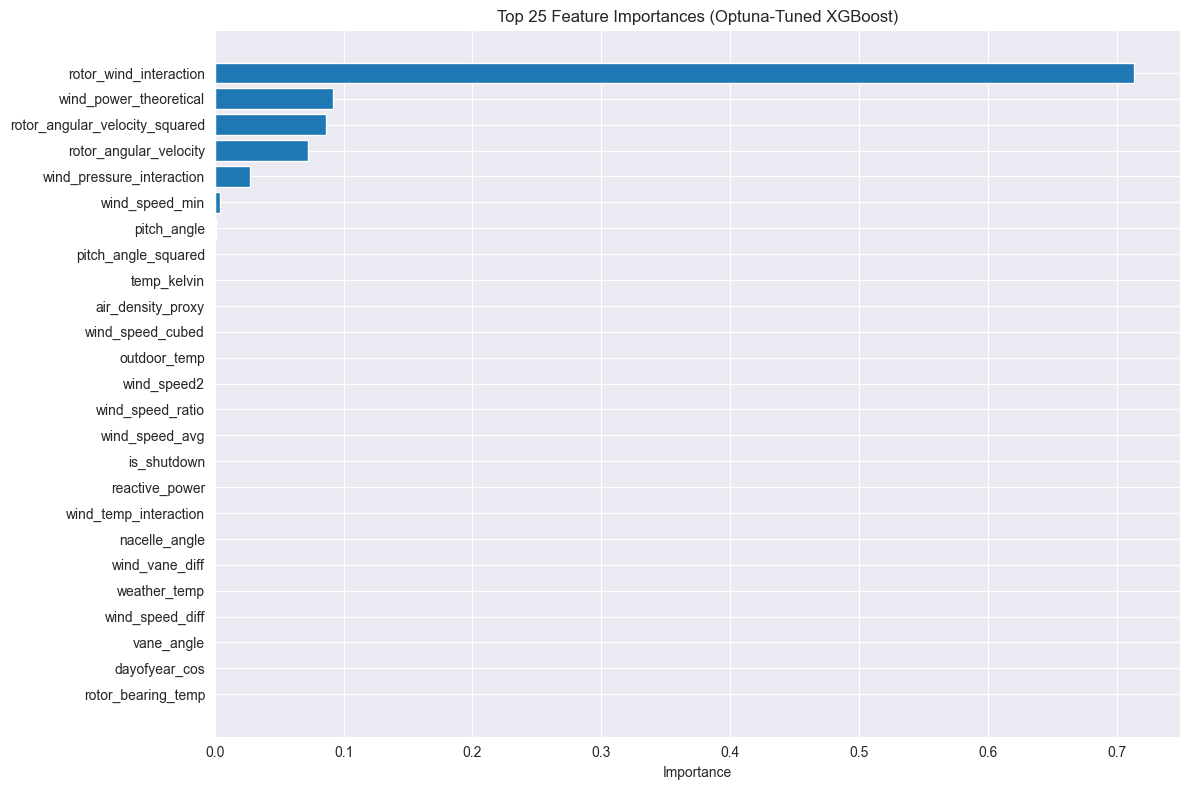

In [11]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': common_features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Plot
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(25)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 25 Feature Importances (Optuna-Tuned XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
# Generate predictions
print("Generating test predictions...")
test_predictions = final_model.predict(X_test_scaled)

# Create submission
submission = pd.DataFrame({
    'id': range(len(test_predictions)),
    'active_power': test_predictions
})

# Clip to physical constraints
submission['active_power'] = submission['active_power'].clip(lower=0, upper=2100)

timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
filename = f'../results/v3_optuna_submission_{timestamp}.csv'
submission.to_csv(filename, index=False)

print(f"\nSubmission saved: {filename}")
print(f"Predictions - Min: {submission['active_power'].min():.2f}, Max: {submission['active_power'].max():.2f}, Mean: {submission['active_power'].mean():.2f}")

Generating test predictions...

Submission saved: ../results/v3_optuna_submission_20251121-182008.csv
Predictions - Min: 0.00, Max: 2073.53, Mean: 356.13


In [13]:
# Save model and study
import pickle

with open('../models/v3_optuna_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

with open('../models/v3_optuna_study.pkl', 'wb') as f:
    pickle.dump(study, f)

with open('../models/v3_feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model, study, and scaler saved")

Model, study, and scaler saved


## 2. Baseline Comparison

This section compares the optimized model against a baseline model with default hyperparameters to assess the effectiveness of the optimization process.

In [14]:
# Train with V1 default parameters (fallback option)
print("Training with default parameters for comparison...")

baseline_model = xgb.XGBRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train_scaled, y_train)
baseline_pred = baseline_model.predict(X_val_scaled)
baseline_mae = mean_absolute_error(y_val, baseline_pred)

print(f"\nDefault Parameters MAE (validation): {baseline_mae:.4f}")
print(f"Optuna Tuned MAE (validation): {val_mae:.4f}")

if baseline_mae < val_mae:
    print("\nDefault parameters perform better.")
    
    # Generate submission with baseline
    baseline_test_pred = baseline_model.predict(X_test_scaled)
    baseline_submission = pd.DataFrame({
        'id': range(len(baseline_test_pred)),
        'active_power': baseline_test_pred.clip(lower=0, upper=2100)
    })
    
    timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
    baseline_filename = f'../results/v3_baseline_fallback_{timestamp}.csv'
    baseline_submission.to_csv(baseline_filename, index=False)
    print(f"Baseline submission saved: {baseline_filename}")
else:
    print("\nOptuna tuning improved performance.")

Training with default parameters for comparison...

Default Parameters MAE (validation): 6.8338
Optuna Tuned MAE (validation): 5.9447

Optuna tuning improved performance.


## 3. Conclusion

The hyperparameter optimization process has been completed, resulting in a tuned XGBoost model that outperforms the baseline.

### Next Steps

1. **Ensemble Methods**: In the next notebook (`03_ensemble_methods.ipynb`), we will combine this optimized XGBoost model with LightGBM and CatBoost to further reduce variance and improve generalization.
2. **Neural Networks**: Finally, in notebook `04_neural_network_approach.ipynb`, we will investigate whether a Deep Learning approach can offer competitive performance on this tabular dataset.